In [129]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import units as u
import astropy.constants as astro_const
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.coordinates import sun
from sunpy.coordinates import SphericalScreen

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is stored
data_dir = '/home/mnedal/data'

In [130]:
def get_forward_map(forward_imagefile, bottom_left=None, top_right=None):
    """
    ========================================================================================
    Function returns a Helioprojective Map from FORWARD outputs.
    Kamen Kozarev, based on code written by Laura Hayes.
    ========================================================================================
    How to create a `~sunpy.map.Map` in Helioprojective Coordinate Frame from FORWARD model.
    In this example we read the data and header information from the FORWARD SAV file and then create 
    a new header with updated WCS information to create a `~sunpy.map.Map` with a HPC coordinate frame. 
    We will make use of the `astropy.coordinates` and `sunpy.coordinates` submodules together with 
    `~sunpy.map.make_fitswcs_header` to create a new header and generate a `~sunpy.map.Map`.
    """
    ##############################################################################
    # We will first begin be reading in the header and data from the SAV file.
    hdul = readsav(forward_imagefile)
    
    #####################################################################################
    # The data in this file is in a datacube structure
    data = np.array(hdul['quantmap'].DATA[0])
    ###############################################################################
    # Lets pull out the observation time and quantity, we will use
    # these to create our new header.
    # Now we need to get the other parameters from the header that will be used
    # to create the new header - here we can get the cdelt1 and cdelt2 which are
    # the spatial scales of the data axes.

    pxrsun = hdul['quantmap'][0][4]
    # obstime = str(hdul['quantmap'][0][5]).split('\'')[1] + 'T12:00:00'
    obstime = str(hdul['quantmap'][0][5]).split('\'')[1]
    quantity = str(hdul['quantmap'][0][6]).split('!')[0].split('\'')[1]
    try:
        units = str(hdul['quantmap'][0][12]).split('\'')[1]
    except:
        units = ''
    rsunasec = 950.
    asecpx = rsunasec * pxrsun
    cdelt1 = asecpx
    cdelt2 = asecpx
    naxis1 = hdul['gridinputs'][0][22]
    naxis2 = hdul['gridinputs'][0][24]
    crpix1 = int(naxis1/2)
    if type(naxis2) == bytes:
        if naxis2.decode('utf-8') == 'NULL':
            crpix2 = ''
        else:
            crpix2 = int(naxis2.decode('utf-8')/2)
    else:
        crpix2 = int(naxis2/2)
    crval1 = 0
    crval2 = 0
    
    ###############################################################################
    # To create a new `~sunpy.map.Map` header we need convert the reference coordinate
    # to Helioprojective. To do this we will first create
    # an `astropy.coordinates.SkyCoord` of the reference coordinate from the header information.
    # We will need the location of the observer (i.e. where the observation was taken).
    reference_coord = SkyCoord(crval1*u.arcsec, crval2*u.arcsec, frame='helioprojective', obstime=obstime)
    ##########################################################################
    
    ##########################################################################
    # Now we can use this information to create a new header using the helper
    # function `~sunpy.map.make_fitswcs_header()`. This will create a MetaDict
    # which we contain all the necessay WCS information to create a `~sunpy.map.Map`.
    new_header = sunpy.map.make_fitswcs_header(data,
                                               reference_coord,
                                               reference_pixel=u.Quantity([crpix1, crpix1]*u.pixel),
                                               scale=u.Quantity([cdelt1, cdelt2]*u.arcsec/u.pix),
                                               rotation_angle=0*u.degree,
                                               observatory='PSIMAS/FORWARD',
                                               instrument=quantity)
    ##########################################################################
    # Lets create a `~sunpy.map.Map`.
    forward_map = sunpy.map.Map(data, new_header)
    ##########################################################################
    ##########################################################################
    # We can now rotate the image so that solar north is pointing up and create
    # a submap in the field of view of interest.
    forward_map_rotate = forward_map.rotate()
    
    if bottom_left is not None:
        bl = SkyCoord(bottom_left[0]*u.arcsec, bottom_left[1]*u.arcsec, frame=forward_map_rotate.coordinate_frame)
    if top_right is not None:
        tr = SkyCoord(top_right[0]*u.arcsec, top_right[1]*u.arcsec, frame=forward_map_rotate.coordinate_frame)
    if bottom_left and top_right:
        forward_submap = forward_map_rotate.submap(bl, top_right=tr)
    else:
        forward_submap = forward_map_rotate
    ##########################################################################
    
    return forward_submap

In [254]:
# load files
file_paths = sorted(glob.glob(f'{data_dir}/FORWARD/*.sav'))
print(*file_paths, sep='\n')

/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BETA_2460559.9840394disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_BMAG_2460559.9356944disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_DENS_2460559.9343750disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_PTOT_2460559.9832407disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_TEMP_2460559.9822801disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VPH_2460593.4820486disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VR_2460593.4744676disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VTH_2460593.4788194disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VX_2460593.5005556disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VY_2460593.5060301disk.sav
/home/mnedal/data/FORWARD/psimas_PHYSICAL_DIAGNOSTICS_VZ_2460593.5081481disk.sav


In [255]:
for file in file_paths:
    if 'BMAG' in file:
        bmag = get_forward_map(file)
    elif 'DENS' in file:
        dens = get_forward_map(file)
    elif 'BETA' in file:
        beta = get_forward_map(file)
    elif 'PRES' in file:
        pres = get_forward_map(file) # thermal pressure (dyne/cm2)
    elif 'PTOT' in file:
        ptot = get_forward_map(file)
    elif 'TEMP' in file:
        temp = get_forward_map(file)
    elif 'BR' in file:
        br = get_forward_map(file)
    elif 'VR' in file:
        vr = get_forward_map(file)
    elif 'VTH' in file:
        vth = get_forward_map(file)
    elif 'VPH' in file:
        vph = get_forward_map(file)
    elif 'VX' in file:
        vx = get_forward_map(file)
    elif 'VY' in file:
        vy = get_forward_map(file)
    elif 'VZ' in file:
        vz = get_forward_map(file)

In [207]:
# Calculate the Alfven speed map
mp = astro_const.m_p.to(u.gram).value
valf_cm_s = bmag.data/np.sqrt(4*np.pi*mp*dens.data)
valf_km_s = valf_cm_s * 1e-5
va = sunpy.map.Map(valf_km_s, dens.meta)

# Calculate plasma speed
vsw_arr = np.sqrt(vr.data**2 + vth.data**2 + vph.data**2)
vsw = sunpy.map.Map(vsw_arr, vr.meta)

# Calculate Alfven Mach number
Ma_arr = vsw.data / va.data
Ma = sunpy.map.Map(Ma_arr, vsw.meta)

In [256]:
# Calculate plasma speed
vsw_arr = np.sqrt(vx.data**2 + vy.data**2 + vz.data**2)
vsw = sunpy.map.Map(vsw_arr, vx.meta)

# Calculate Alfven Mach number
Ma_arr = vsw.data / va.data
Ma = sunpy.map.Map(Ma_arr, vsw.meta)

In [179]:
vr.data.shape

(512, 512)

In [80]:
def generate_centered_list(center, difference, num_elements):
    """
    Generate a list of numbers centered around a given number with a specified difference
    between consecutive numbers.

    Parameters:
    center (int): The central number around which the list is generated.
    difference (int): The difference between consecutive numbers in the list.
    num_elements (int): The number of elements before and after the central number.

    Returns:
    list: A list of numbers centered around the specified central number.
    """
    return [center + difference * i for i in range(-num_elements, num_elements + 1)]


def plot_line(angle_deg=None, length=None, map_obj=None):
    """
    Plot a straight line at an angle in degrees from the solar West.
    """
    angle_rad = np.deg2rad(angle_deg)
    
    # Define the length of the line (in arcseconds)
    line_length = length * u.arcsec
    
    # Define the center point of the line (e.g., the center of the Sun)
    center = SkyCoord(0*u.arcsec, 0*u.arcsec, frame=map_obj.coordinate_frame)
    
    # Calculate the start and end points of the line
    start_point = SkyCoord(center.Tx, center.Ty, frame=map_obj.coordinate_frame)
    end_point   = SkyCoord(center.Tx + line_length * np.cos(angle_rad), 
                           center.Ty + line_length * np.sin(angle_rad),
                           frame=map_obj.coordinate_frame)
    
    line = SkyCoord([start_point, end_point])
    return line

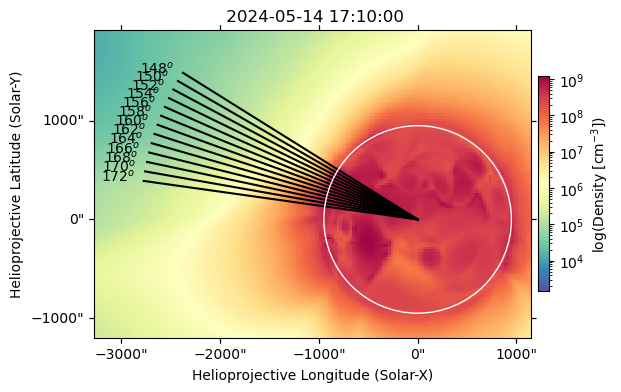

In [81]:
centered_list = generate_centered_list(160, 2, 6)

fig = plt.figure(figsize=[10,4])
# fig = plt.figure()
ax = fig.add_subplot(111, projection=dens)
img = dens.plot(axes=ax,
                norm=colors.LogNorm(),
                cmap='Spectral_r')
dens.draw_limb()
ax.grid(False)
plt.colorbar(img, ax=ax, shrink=0.7, pad=0.01, label='log(Density [cm$^{-3}$])')

sampled_dens = []
sampled_dist = []

for value in centered_list:
    line = plot_line(angle_deg=value, length=2800, map_obj=dens)
    ax.plot_coord(line, color='black')
    
    # Plot the number at the end of the line
    # Convert SkyCoord to pixel coordinates for plotting text
    line_lon, line_lat = line.Tx, line.Ty
    end_point_pixel = dens.world_to_pixel(SkyCoord(line_lon[1], line_lat[1], frame=dens.coordinate_frame))
    
    # Display the number at the end point
    ax.text(end_point_pixel.x.value-10, end_point_pixel.y.value+2, f'{value}$^o$',
            color='black', fontsize=10, ha='center', va='center')

    # sample values along slits
    with SphericalScreen(dens.observer_coordinate):
        traced_loop_pixelated = sunpy.map.pixelate_coord_path(dens, line)
        traced_loop_distance = traced_loop_pixelated.separation(traced_loop_pixelated[0])
    vals = sunpy.map.sample_at_coords(dens, traced_loop_pixelated)
    sampled_dens.append(vals)
    sampled_dist.append(traced_loop_distance.to('arcsec'))

ax.set_xlim(left=130, right=300)
ax.set_ylim(bottom=210, top=330)
fig.tight_layout()
plt.show()

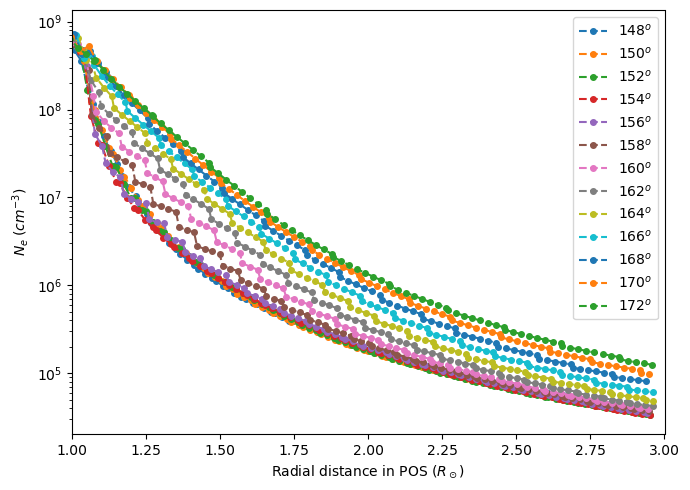

In [84]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(111)

for i in range(len(sampled_dens)):
    ax.plot(sampled_dist[i]/dens.rsun_obs.value, sampled_dens[i], 'o--', ms=4, label=f'{centered_list[i]}$^o$')
    ax.set_yscale('log')

ax.legend(loc='best')
ax.set_xlabel('Radial distance in POS ($R_\odot$)')
ax.set_ylabel('$N_e\;(cm^{-3})$')
ax.set_xlim(left=1, right=3)
fig.tight_layout()
plt.show()

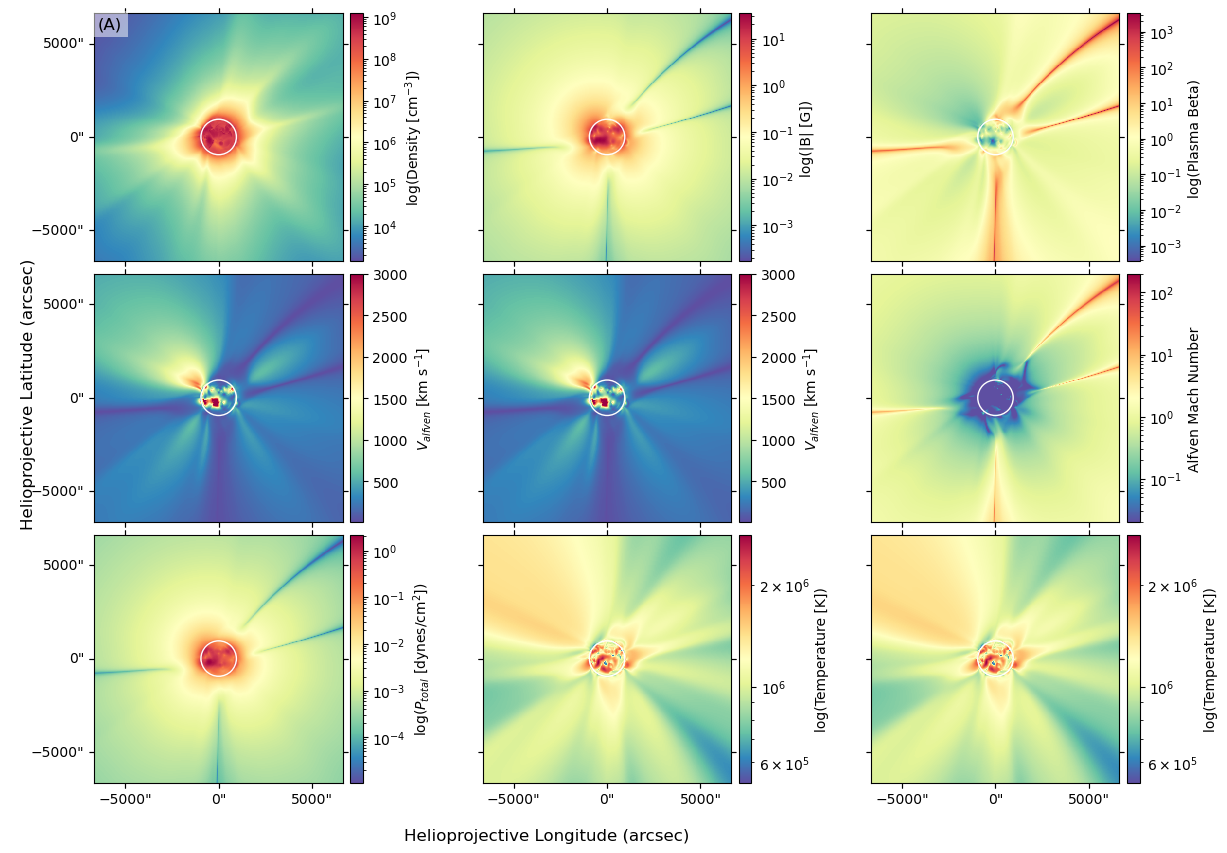

In [293]:
fig = plt.figure(figsize=[15,10])
fig.supxlabel('Helioprojective Longitude (arcsec)', y=0.05)
fig.supylabel('Helioprojective Latitude (arcsec)', x=0.15)

ax = fig.add_subplot(331, projection=dens)
img = dens.plot(axes=ax,
                norm=colors.LogNorm(),
                cmap='Spectral_r')
dens.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(Density [cm$^{-3}$])')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.text(0.015, 0.985, '(A)', transform=ax.transAxes, fontsize=12, color='k',
        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax = fig.add_subplot(332, projection=bmag)
img = bmag.plot(axes=ax,
                norm=colors.LogNorm(),
                cmap='Spectral_r')
bmag.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(|B| [G])')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(333, projection=beta)
img = beta.plot(axes=ax,
            norm=colors.LogNorm(),
            cmap='Spectral_r')
beta.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(Plasma Beta)')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(334, projection=va)
img = va.plot(axes=ax,
            vmin=1e1, vmax=3e3,
            cmap='Spectral_r')
va.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='$V_{alfven}$ [km s$^{-1}$]')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
# ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(335, projection=va)
img = va.plot(axes=ax,
            vmin=1e1, vmax=3e3,
            cmap='Spectral_r')
va.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='$V_{alfven}$ [km s$^{-1}$]')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(336, projection=Ma)
img = Ma.plot(axes=ax,
            norm=colors.LogNorm(vmin=2e-2, vmax=2e2),
            cmap='Spectral_r')
Ma.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='Alfven Mach Number')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(337, projection=ptot)
img = ptot.plot(axes=ax,
            norm=colors.LogNorm(),
            cmap='Spectral_r')
ptot.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log($P_{total}$ [dynes/cm$^2$])')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
# ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(338, projection=temp)
img = temp.plot(axes=ax,
            norm=colors.LogNorm(),
            cmap='Spectral_r')
temp.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(Temperature [K])')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)

ax = fig.add_subplot(339, projection=temp)
img = temp.plot(axes=ax,
            norm=colors.LogNorm(),
            cmap='Spectral_r')
temp.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='log(Temperature [K])')
ax.grid(False)
ax.set_title('')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.coords[1].set_ticklabel_visible(False)

# fig.tight_layout()
# fig.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01)
plt.subplots_adjust(
    # left=0.05, right=0.95, top=0.95, bottom=0.05,
    wspace=0.007, hspace=0.05)
# fig.savefig(f'{data_dir}/forward_{dens.latex_name[1:].replace(" ","T")}.pdf',format='pdf', bbox_inches='tight')
plt.show()

In [127]:
dens.meta

MetaDict([('wcsaxes': '2')
('crpix1': '257.0')
('crpix2': '257.0')
('cdelt1': '25.9765625')
('cdelt2': '25.9765625')
('cunit1': 'arcsec')
('cunit2': 'arcsec')
('ctype1': 'HPLN-TAN')
('ctype2': 'HPLT-TAN')
('crval1': '0.0')
('crval2': '0.0')
('lonpole': '180.0')
('latpole': '0.0')
('mjdref': '0.0')
('date-obs': '2024-05-14T17:10:00.000')
('rsun_ref': '695700000.0')
('instrume': '2284_HMI_THERMO_HIGH_H2.dat')
('obsrvtry': 'PSIMAS/FORWARD')
('naxis': '2')
('naxis1': '512')
('naxis2': '512')
('pc1_1': '1.0')
('pc1_2': '0.0')
('pc2_1': '0.0')
('pc2_2': '1.0')])

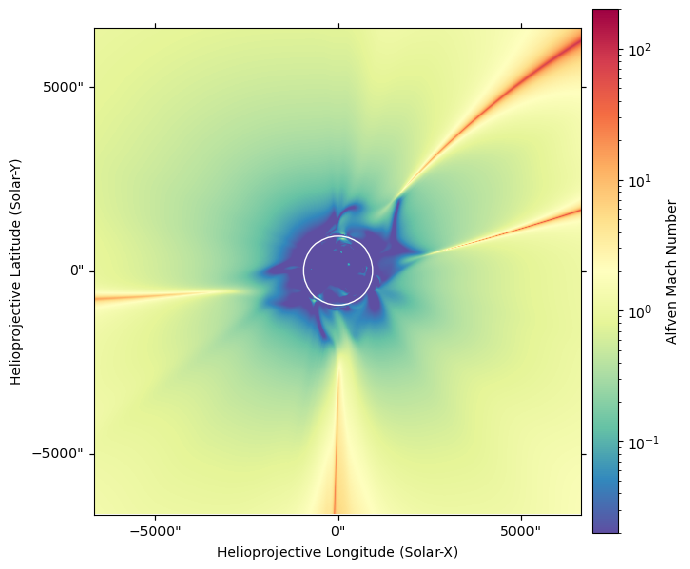

In [296]:
# Test ...
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=Ma)
img = Ma.plot(axes=ax,
              # vmin=-1, vmax=10,
              # norm=colors.LogNorm(),
              norm=colors.LogNorm(vmin=2e-2, vmax=2e2),
            # norm=colors.LogNorm(vmin=1e-2, vmax=1e2),
            cmap='Spectral_r')
Ma.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label='Alfven Mach Number')
ax.grid(False)
ax.set_title('')
fig.tight_layout()
plt.show()

In [253]:
# Test ...
1e0, 1e-1, 1e1

(1.0, 0.1, 10.0)

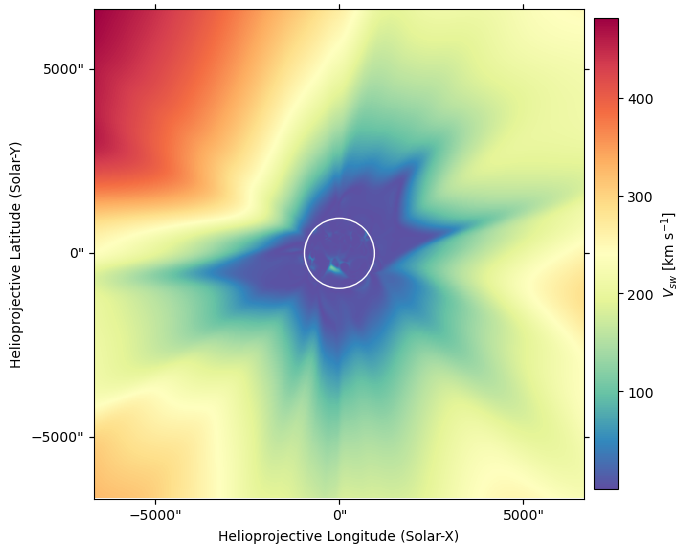

In [295]:
# Test ...
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=vsw)
img = vsw.plot(axes=ax,
              # vmin=0, vmax=500,
                # norm=colors.LogNorm(),
                cmap='Spectral_r')
vsw.draw_limb()
ax.grid(False)
ax.set_title('')
plt.colorbar(img, ax=ax, fraction=0.045, pad=0.02, label='$V_{sw}$ [km s$^{-1}$]')
fig.tight_layout()
plt.show()

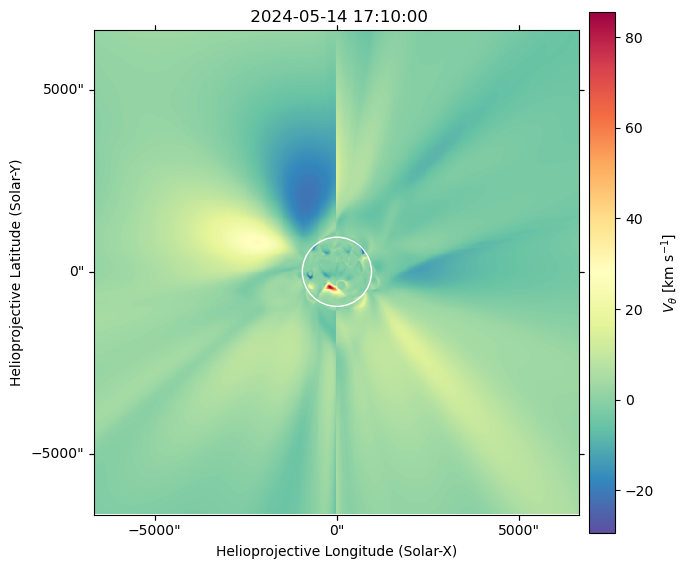

In [201]:
# Test ...
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(projection=vth)
img = vth.plot(axes=ax,
              # vmin=0, vmax=40,
                # norm=colors.LogNorm(),
                cmap='Spectral_r')
vth.draw_limb()
plt.colorbar(img, ax=ax, fraction=0.05, pad=0.02, label=r'$V_{\theta}$ [km s$^{-1}$]')
ax.grid(False)
fig.tight_layout()
plt.show()